In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

['sample_submission_ns2btKE.csv', 'train', 'test_ApKoW4T.csv']


In [2]:
train = pd.read_csv('../input/train/train.csv')
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
from fastai import *

In [4]:
from fastai.vision import *
from fastai.basics import *

In [5]:
ls '../input/'

sample_submission_ns2btKE.csv  test_ApKoW4T.csv  train/


In [6]:
path= Path('../input/train/')

In [7]:
'../input/train/'

'../input/train/'

In [8]:
tfms=get_transforms()
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, res

In [11]:
data = (ImageList .from_csv(path, folder='images', csv_name='train.csv', cols='image')
       #.use_partial_data(sample_pct = .1, seed= 34)
       .split_by_rand_pct(valid_pct=0.1, seed=34)
       .label_from_df(cols='category')
        .add_test_folder(Path('../input/test_ApKoW4T.csv'))
       .transform(tfms, size = 224)
       .databunch(bs=16)).normalize(imagenet_stats)

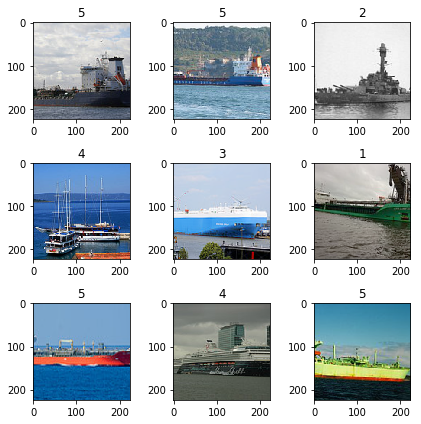

In [12]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [13]:
import os
model_dir="/tmp/model/"
if not os.path.exists ("/tmp/model/"):
    !mkdir "/tmp/model/"
learn = cnn_learner(data, models.densenet161,model_dir="/tmp/model/",metrics=[FBeta(beta=1),accuracy])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:04, 27678840.87it/s]


In [14]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.577815,0.361734,0.877754,0.865600,01:47
1,0.378703,0.212062,0.930124,0.923200,01:36
2,0.259009,0.189762,0.937439,0.932800,01:37
3,0.219683,0.156491,0.948315,0.942400,01:38
4,0.181408,0.161582,0.951056,0.945600,01:37


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

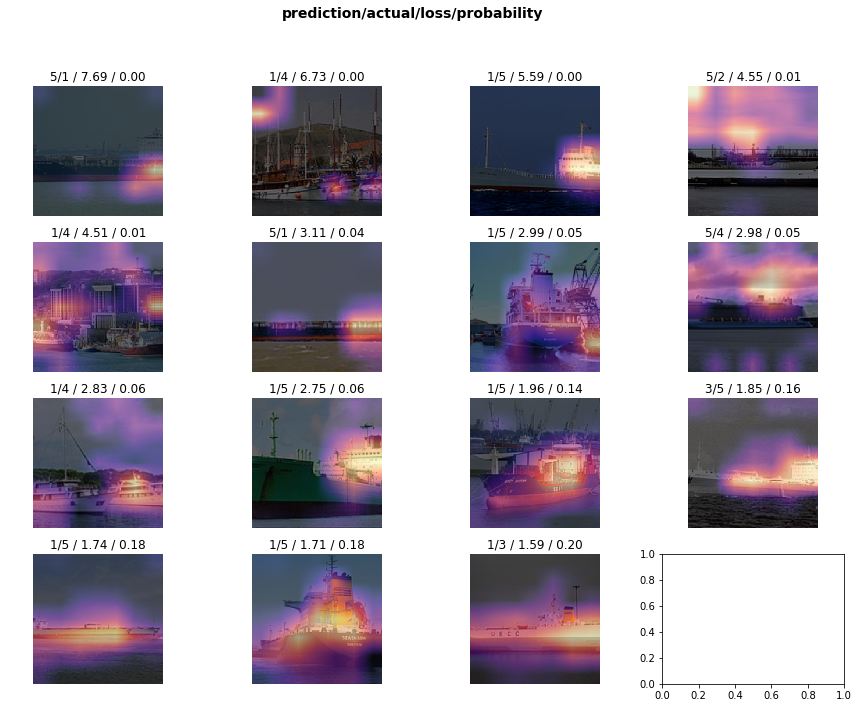

In [16]:
interp.plot_top_losses(15, figsize=(15,11))

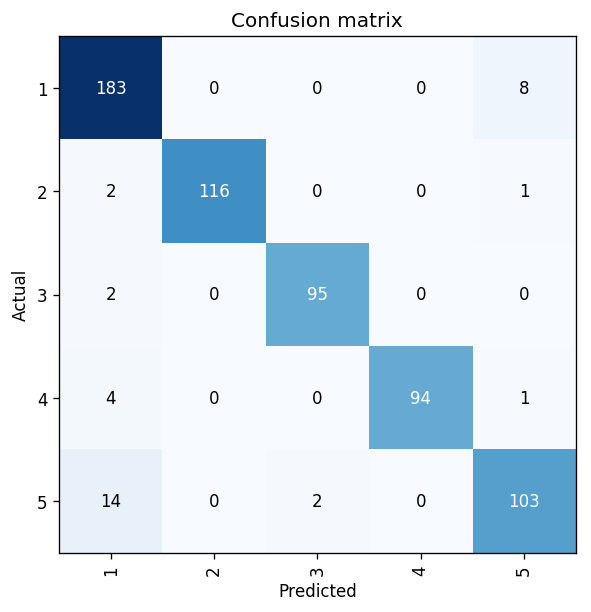

In [17]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=120)

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


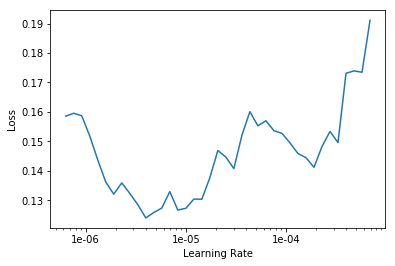

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-6))

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.173530,0.150349,0.955693,0.952000,01:55
1,0.164679,0.147169,0.956977,0.952000,01:56
2,0.152694,0.142879,0.958321,0.953600,01:57
3,0.149791,0.147279,0.956883,0.952000,01:57
4,0.127174,0.136896,0.959956,0.955200,01:56


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


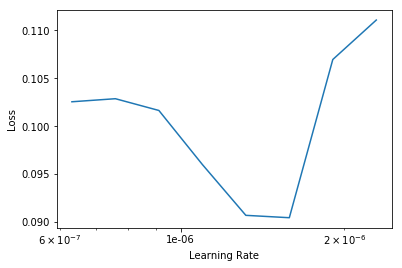

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-6
lrs=np.array([lr/10,lr/3,lr])
learn.unfreeze()
learn.fit(5,lrs)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.132573,0.141041,0.956383,0.952000,01:56
1,0.134641,0.137742,0.961091,0.956800,01:55
2,0.134633,0.135042,0.962709,0.958400,01:57
3,0.128740,0.137306,0.960876,0.956800,01:57
4,0.133414,0.135570,0.961067,0.956800,01:57


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


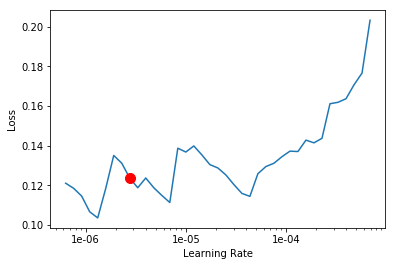

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [24]:
lr = 0.5e-4
lrs=np.array([lr/10,lr/3,lr])
learn.unfreeze()
learn.fit(5,lrs)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.160875,0.132180,0.959463,0.955200,01:54
1,0.124497,0.133821,0.965590,0.961600,01:55
2,0.090968,0.132124,0.964187,0.960000,01:56
3,0.097877,0.152554,0.961237,0.956800,01:57
4,0.083365,0.130442,0.966919,0.963200,01:57


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [25]:
train.shape

(6252, 2)

In [26]:
t  = pd.read_csv('../input/test_ApKoW4T.csv')
t.shape[0]

2680

In [27]:
data.add_test(items=[path/'images'/i for i in t['image'].tolist()],label=None)

In [28]:
data.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f9ea1fc5ef0>, device=device(type='cuda', index=0), tfms=[functools.partial(<function _normalize_batch at 0x7f9eaa654ea0>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f9eb1817620>)

In [ ]:
preds, y = learn.TTA(beta=0.3,ds_type=DatasetType.Test)

In [30]:
preds.shape

torch.Size([2680, 5])

In [31]:
imgName = t['image'].tolist()
#imgName

In [32]:
preds_  = torch.argmax(preds,1)+1
preds_

tensor([4, 4, 4,  ..., 1, 4, 4])

In [33]:
preds_ = preds_.numpy()
preds_

array([4, 4, 4, 2, ..., 4, 1, 4, 4])

In [34]:
pd.Series(preds_).value_counts()

1    922
5    511
2    505
3    390
4    352
dtype: int64

In [35]:
predsDF = pd.DataFrame()
predsDF['image'] = imgName
predsDF['category'] = preds_
predsDF.head(20)

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4
5,1072861.jpg,4
6,1097264.jpg,4
7,1098763.jpg,2
8,1098766.jpg,2
9,1101145.jpg,4


In [36]:
t.head(20)

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
5,1072861.jpg
6,1097264.jpg
7,1098763.jpg
8,1098766.jpg
9,1101145.jpg


In [37]:
sum(predsDF['image'] == t['image']) == t.shape[0]

True

In [39]:
predsDF.to_csv('preds_densenet161_beta_0.3.csv',index=False)
from IPython.display import FileLink, FileLinks
FileLink('preds_densenet161_beta_0.3.csv')

/kaggle/working/preds_densenet161_beta_0.4.csv